# Introduction

The aim of this project is to identify which factors predict user adoption by defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period


The data is available as two attached CSV files and each data set has the following information:<br>

1.`takehome_users.csv`<br>
A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:<br>
 ● **name:** the user's name <br>
 ● **object_id:** the user's id <br>
 ● **email:** email address <br>
 ● **creation_source**: how their account was created. This takes on one of 5 values:<br>
           ○ **PERSONAL_PROJECTS:** invited to join another user's personal workspace<br>
           ○ **GUEST_INVITE:** invited to an organization as a guest (limited permissions)<br>
           ○ **ORG_INVITE:** invited to an organization (as a full member) <br>
           ○ **SIGNUP:** signed up via the website <br>
           ○ **SIGNUP_GOOGLE_AUTH:** signed up using Google Authentication (using a Google email account for their login id)<br>
 ● **creation_time:** when they created their account <br>
 ● **last_session_creation_time:** unix timestamp of last login <br>
 ● **opted_in_to_mailing_list:** whether they have opted into receiving marketing emails <br>
 ● **enabled_for_marketing_drip:** whether they are on the regular marketing email drip <br>
 ● **org_id:** the organization (group of users) they belong to <br>
 ● **invited_by_user_id:** which user invited them to join (if applicable) <br>
 ● **user_id:** which user invited them to join (if applicable) <br>

2. `takehome_user_engagement.csv`<br>
A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [45]:
# Load and examine the data 
user_engagement_df= pd.read_csv(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Relax Challenge\takehome_user_engagement.csv")
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


**Note:** 'takehome_users.csv' was re-encoded to utf-8 to allow proper opening.

In [46]:
users_df=pd.read_csv(r"C:\Users\Bara Elshaer\Documents\Python\Data Science\Relax Challenge\takehome_users.csv", encoding="latin-1")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [47]:
# Examining the user data to see who is using the application 

'''
I am passing the user engagement table because I want to count all the users who are actually using the application. 
'''
a= len(list(user_engagement_df['user_id'].unique()))
print('Total number of active users of the application:', a)

'''
I am passing the takehome user table because I want to count the total number of people who signed up regardless of 
their activity status.
'''
b= len(list(users_df['object_id'].unique()))
print('Total number of users who signed up for the application:', b)

print('Total number of user discrepancy:', b-a)

Total number of active users of the application: 8823
Total number of users who signed up for the application: 12000
Total number of user discrepancy: 3177


I can confirm the math of inactive users (the users who never signed in) by executing the following code block:

In [48]:
print('Total number of inactive users:', 
      len(user_info_df[user_info_df['last_session_creation_time'].isnull()]))

Total number of inactive users: 3177


# Data Wrangling

In [49]:
# Checking for missing data in the user engagement table
print(user_engagement_df.isnull().any())

time_stamp    False
user_id       False
visited       False
dtype: bool


In [50]:
# Checking for missing data in the user information table
print(users_df.isnull().any())

object_id                     False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
dtype: bool


In [51]:
'''
Checking to see how much missing data there is in the last_session_creation_time column and invited_by_user_id column 
'''
print(users_df['invited_by_user_id'].isnull().value_counts())

print(users_df['last_session_creation_time'].isnull().value_counts())

False    6417
True     5583
Name: invited_by_user_id, dtype: int64
False    8823
True     3177
Name: last_session_creation_time, dtype: int64


There is a significant number of missing values from `invited_by_user_id` and `last_session_creation_time`, which is 5583 and 3177 respectively.

In [52]:
# Change to datetime object
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

In [53]:
# time to add in the adopted user feature so that we can categorize the data

seven_days=datetime.timedelta(7)
adopted= {}

for user_id in sorted(list(user_engagement_df['user_id'].unique())):
    
    adopted_user =  False
    temp= user_engagement_df[user_engagement_df['user_id']== user_id]
    temp= temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue 
        this_time= temp.at[row[0], 'time_stamp']
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp']<= (this_time + seven_days))]) >= 3:
            
            adopted_user= True
    
    adopted[user_id]= adopted_user

In [54]:
# Calculating the percentage of active users 

count_df= pd.DataFrame.from_dict(Counter(list(adopted.values())), orient='index').reset_index()
unique_users=len(adopted)
print('Total number of unique users:',unique_users)

count_df

Total number of unique users: 8823


,index,0
0,False,7167
1,True,1656


In [55]:
'''
Using the meaning of adopted user, there is a total number of 1656 users who fit the definition
'''
percent=(1656/unique_users)*100
print('Percent of users that fit the definition of adopted-users:',percent)

Percent of users that fit the definition of adopted-users: 18.769126147568855


In [17]:
# Create adopted target variable and display dataset again
users_df['adopted'] = False
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


In [23]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [24]:
# Check on the higher risk/more defined features
for feature in ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    print('{} feature:'.format(feature))
    print(users_df[feature].value_counts(), end='\n\n')

creation_source feature:
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

opted_in_to_mailing_list feature:
0    9006
1    2994
Name: opted_in_to_mailing_list, dtype: int64

enabled_for_marketing_drip feature:
0    10208
1     1792
Name: enabled_for_marketing_drip, dtype: int64



In [25]:
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(users_df['last_session_creation_time'].median())


users_df['creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
# day of the week account created
users_df['day_created'] = users_df['creation_time'].apply(lambda x: x.dayofweek)
# hour of the day account created
users_df['hour_created'] = users_df['creation_time'].apply(lambda x: x.hour)
# drop the original column
users_df.drop('creation_time', axis=1, inplace=True)

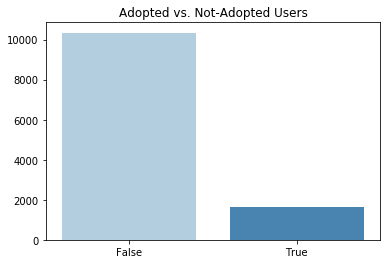

In [26]:
# Take another look at the distribution of the target class
sns.barplot(x = list(users_df['adopted'].value_counts().index), y = users_df['adopted'].value_counts(), palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

As there is a heavy imbalance in the classes here I will split the data into training and testing data and then oversample the training the data to balance out the classes w/o distorting the testing data.

In [27]:
users_df.drop(['name', 'email', 'invited_by_user_id', 'object_id'], axis=1, inplace=True)

In [28]:
users_df.head()

,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,day_created,hour_created
0,GUEST_INVITE,1.398139e+09,1,0,11,False,3,0
1,ORG_INVITE,1.396238e+09,0,0,1,True,3,0
2,ORG_INVITE,1.363735e+09,0,0,94,False,3,0
3,GUEST_INVITE,1.369210e+09,0,0,1,False,3,0
4,GUEST_INVITE,1.358850e+09,0,0,193,False,3,0


In [29]:
# One-hot-encode creation_source
df_encoded = pd.get_dummies(users_df, columns = ['creation_source'])

In [30]:
X = df_encoded.drop('adopted', axis=1)
y = df_encoded['adopted']

In [31]:
# Split into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, 
                                                           random_state=2007, stratify=users_df['adopted'])


In [32]:
y_train.head()

5655    False
7390    False
3313    False
8560    False
1656    False
Name: adopted, dtype: bool

In [33]:
X_train.head()

,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,day_created,hour_created,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
5655,1.382888e+09,1,0,216,3,0,0,1,0,0,0
7390,1.360001e+09,0,0,220,3,0,0,0,1,0,0
3313,1.391318e+09,0,0,274,3,0,0,1,0,0,0
8560,1.399979e+09,0,0,44,3,0,0,1,0,0,0
1656,1.382888e+09,0,0,412,3,0,0,0,1,0,0


An imbalanced dataset is a dataset where the number of data points per class differs drastically, resulting in a heavily biased machine learning model that won’t be able to learn the minority class. When this imbalanced ratio is not so heavily skewed toward one class, such dataset is not that horrible, since many machine learning models can handle them. Data oversampling is a technique applied to generate data in such a way that it resembles the underlying distribution of the real data. In this project, I will use an oversampling technique called Synthetic Minority Over-Sampling Technique or SMOTE to balance out our dataset. SMOTE is an oversampling algorithm that relies on the concept of nearest neighbors to create its synthetic data.

In [34]:
#SMOTE oversampling to balance out the classes

from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = ADASYN().fit_sample(X_train, y_train)
# X_resampled, y_resampled = X_train, y_train
#ADASYN().fit_sample(X, y)

print(sorted(Counter(y_resampled).items()))


Using TensorFlow backend.


[(False, 7241), (True, 7161)]


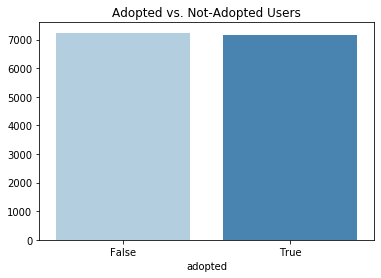

In [35]:
# Take a look at the distribution of the enhanced target class
sns.countplot(y_resampled, palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

# Predictive Models and Feature Importance

I will begin by examining the OOB performance of several different relevant model in order to glean the best one to start with and then fine tune.

In [37]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [39]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [40]:
names = []
scores = []
for name, model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  2.94it/s]


  Name     Score
0  KNN  0.909167
1  SVC  0.861944
2   LR  0.861944
3   DT  0.876667
4  GNB  0.861944
5   RF  0.913056
6   GB  0.913889


In [42]:
names = []
scores = []
for name, model in tqdm(models):
    
    kfold = KFold(n_splits=10, random_state=None) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(kf_cross_val)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:25<00:00,  3.85s/it]


  Name     Score
0  KNN  0.910500
1  SVC  0.862000
2   LR  0.862000
3   DT  0.869917
4  GNB  0.862000
5   RF  0.911083
6   GB  0.918333


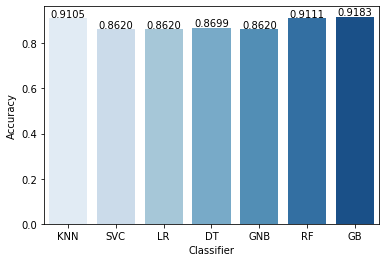

In [43]:
# Visualize model model scores
axis = sns.barplot(x = 'Name', y = 'Score', data = kf_cross_val, palette='Blues')
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

Train and tune a single model.

In [56]:
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.7090            0.59s
         2           0.6539            0.73s
         3           0.6143            0.74s
         4           0.5839            0.72s
         5           0.5597            0.70s
         6           0.5399            0.69s
         7           0.5235            0.66s
         8           0.5099            0.67s
         9           0.4975            0.70s
        10           0.4878            0.71s
        20           0.4371            0.60s
        30           0.4208            0.48s
        40           0.4120            0.39s
        50           0.4024            0.32s
        60           0.3945            0.25s
        70           0.3878            0.19s
        80           0.3828            0.12s
        90           0.3799            0.06s
       100           0.3751            0.00s
Train Score: 0.929
Test Score: 0.914


In [57]:
# TP / FP 
confusion_matrix(y_test, clf.predict(X_test))

array([[2986,  117],
       [ 193,  304]], dtype=int64)

Examine the model feature importance.

In [58]:
clf.feature_importances_.shape


(11,)

In [59]:
features = pd.Series(clf.feature_importances_, index=X.columns)

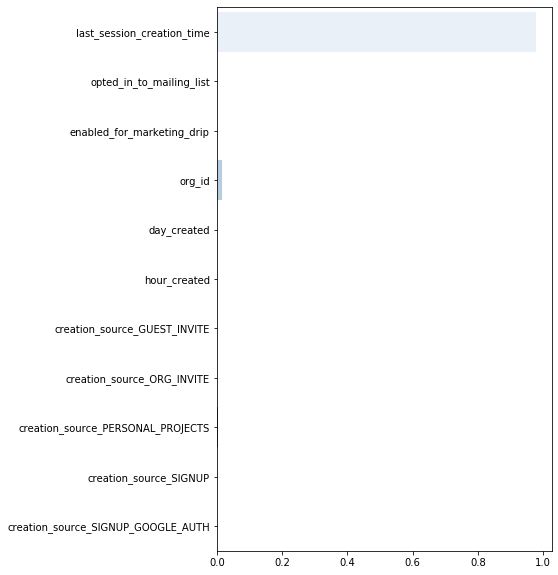

In [61]:
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=clf.feature_importances_, palette='Blues')

In [62]:
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,9.766500e-01
org_id,1.689499e-02
creation_source_PERSONAL_PROJECTS,2.634997e-03
creation_source_GUEST_INVITE,1.432667e-03
enabled_for_marketing_drip,1.223438e-03
opted_in_to_mailing_list,7.433294e-04
creation_source_SIGNUP,4.199003e-04
creation_source_ORG_INVITE,6.449306e-07
creation_source_SIGNUP_GOOGLE_AUTH,6.288634e-09
day_created,0.000000e+00


As can be seen above the most important feature is the most recent log-in time. Below I try some hyperparameter tunning:

In [64]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                                min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=2007), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
    

In [72]:
gsearch1.cv_results_

{'mean_fit_time': array([0.10032969, 0.13284431, 0.1859025 , 0.20006557, 0.27606025,
        0.2836411 , 0.33789539]),
 'std_fit_time': array([0.01711903, 0.02496473, 0.03174997, 0.02653488, 0.04483023,
        0.03490755, 0.03936336]),
 'mean_score_time': array([0.00438819, 0.00438824, 0.00498681, 0.00498652, 0.004987  ,
        0.00618353, 0.0065886 ]),
 'std_score_time': array([1.01745766e-03, 4.88305361e-04, 8.92016666e-04, 1.09257988e-03,
        2.61174468e-07, 9.77106667e-04, 7.93372471e-04]),
 'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 20},
  {'n_estimators': 30},
  {'n_estimators': 40},
  {'n_estimators': 50},
  {'n_estimators': 60},
  {'n_estimators': 70},
  {'n_estimators': 80}],
 'split0_test_score': array([0.88682746, 0.89016608, 0.89279963, 0.89664315, 0.89950526,
        0.90194163, 0.90244504]),

In [74]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=60, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=2007), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)

gsearch2.fit(X_train,y_train)

gsearch2.cv_results_

{'mean_fit_time': array([0.2543097 , 0.22807145, 0.22182403, 0.22886291, 0.2122427 ,
        0.29929242, 0.2852634 , 0.22938609, 0.22260971, 0.2277072 ,
        0.31930046, 0.30305209, 0.28894601, 0.27447343, 0.22531385,
        0.39589095, 0.30837493, 0.26927814, 0.29022861, 0.25472541,
        0.43059435, 0.37235732, 0.3533947 , 0.30617595, 0.29577632,
        0.52805715, 0.42265892, 0.31435966, 0.31733246, 0.26269741]),
 'std_fit_time': array([0.0217409 , 0.03364884, 0.01821898, 0.01630454, 0.01328355,
        0.03301597, 0.03418619, 0.04064913, 0.03655147, 0.03523201,
        0.03613095, 0.06957914, 0.02061007, 0.02636418, 0.02945009,
        0.05348092, 0.04594818, 0.02579472, 0.02759276, 0.03044314,
        0.03358859, 0.05159066, 0.03602553, 0.03364964, 0.03385441,
        0.05788503, 0.09262865, 0.01542978, 0.06039924, 0.03400133]),
 'mean_score_time': array([0.00312438, 0.00312428, 0.00312419, 0.0041894 , 0.00498676,
        0.00937252, 0.00791154, 0.00578446, 0.00538535, 0.00

In [76]:
clf_tuned = GradientBoostingClassifier(learning_rate=0.05, 
                                       n_estimators=70, 
                                       max_features='auto', 
                                       subsample=0.85,
                                       max_depth= 6,
                                       min_samples_split= 800,
                                       random_state=2007,
                                       verbose=True)

In [77]:
clf_tuned.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7515           0.0514            0.60s
         2           0.7088           0.0396            0.63s
         3           0.6850           0.0263            0.62s
         4           0.6612           0.0259            0.62s
         5           0.6324           0.0237            0.66s
         6           0.6222           0.0197            0.66s
         7           0.6036           0.0147            0.66s
         8           0.5838           0.0155            0.66s
         9           0.5808           0.0121            0.67s
        10           0.5586           0.0127            0.66s
        20           0.4787           0.0055            0.50s
        30           0.4495           0.0017            0.37s
        40           0.4172           0.0004            0.29s
        50           0.4080           0.0002            0.19s
        60           0.4133           0.0004            0.10s
       

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=6,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=800,
                           min_weight_fraction_leaf=0.0, n_estimators=70,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2007, subsample=0.85, tol=0.0001,
                           validation_fraction=0.1, verbose=True,
                           warm_start=False)

In [78]:
print('Train Score:', round(clf_tuned.score(X_train,y_train),3))
print('Test Score:', round(clf_tuned.score(X_test,y_test),3))

Train Score: 0.925
Test Score: 0.915


# Conclusion:

With approximatly **81%** of the userbase no considered non adoptive users, we have an obvious area for improvment in user engagment. This is also exemplified by the fact that we have several thousand users who, after creating an account, never engaged with the system (loged in). From the feature importances the last log in time was the most highly correlated with a positive prediction, which is not surprising. However, I am not certain how useful the is as a real world predictor as those who have logged in more recently are more likely to be in the engaged crowed, and thus this dilutes its usefulness as a predictor of whether or not a novel user will become an adopted user. My recommendations at this point would be to identify the top sources of engaged users (sign-up origin) and increase marketing efforts there. Further, we can conduct more detailed surveys amoungst adopted users to attempt to identify new commonfeatures to add to the model that may increase its validity. 